In [134]:
import pandas as pd

# Specify the file path of the CSV file
csv_file = 'processed.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
#df.head()

df = df.drop(0)
renamed_df = df.rename(columns={
    'Products and product groups': 'Product_Groups',
    'Alcoholic beverages, tobacco products and recreational cannabis': 'Sins',
    'All-items': 'All',
    'Clothing and footwear': 'Clothing/Shoes',
    'Food': 'Food',
    'Health and personal care': 'Health/Personal-Care',
    'Household operations, furnishings and equipment': 'Household/Furnishing/Equipment',
    'Recreation, education and reading': 'Recreation/Education/Reading',
    'Shelter': 'Shelter',
    'Transportation': 'Transpo',
    'All-items excluding food':'X-Food',
    'All-items excluding food and energy':'X-Food/Energy'	
})

#renamed_df 

renamed_df = renamed_df.reset_index(drop=True)
columns_to_drop = ['All', 'X-Food','X-Food/Energy']
renamed_df = renamed_df.drop(columns_to_drop, axis=1)
renamed_df

renamed_df['Date'] = pd.to_datetime(renamed_df['Date'], format='%b-%y')
renamed_df.set_index('Date', inplace=True)
renamed_df

df=renamed_df
lag_periods = 1  # Number of periods to lag

for col in df.columns:
    lagged_col = 'lag_'+col  
    df[lagged_col] = df[col].shift(lag_periods)
df = df.drop('1992-02-01')



start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-05-01')

extracted_data = df[(df.index >= start_date) & (df.index <= end_date)]
extracted_data


,Sins,Clothing/Shoes,Food,Health/Personal-Care,Household/Furnishing/Equipment,Recreation/Education/Reading,Shelter,Transpo,lag_Sins,lag_Clothing/Shoes,lag_Food,lag_Health/Personal-Care,lag_Household/Furnishing/Equipment,lag_Recreation/Education/Reading,lag_Shelter,lag_Transpo
Date,,,,,,,,,,,,,,,,
2023-01-01,0.701944,-0.312175,0.951315,0.492958,-0.376790,0.000000,0.119190,-0.237248,0.270709,0.945378,0.506187,0.566572,-0.075301,-0.160256,0.358852,-0.881834
2023-02-01,0.482574,0.835073,0.443459,0.490540,0.832073,-0.240770,0.178571,-0.772889,0.701944,-0.312175,0.951315,0.492958,-0.376790,0.000000,0.119190,-0.237248
2023-03-01,0.693703,0.310559,0.441501,0.557880,-0.075019,0.482703,0.356506,-0.239664,0.482574,0.835073,0.443459,0.490540,0.832073,-0.240770,0.178571,-0.772889
2023-04-01,0.211977,-0.103199,0.549451,0.554785,0.000000,0.880705,0.592066,0.480480,0.693703,0.310559,0.441501,0.557880,-0.075019,0.482703,0.356506,-0.239664
2023-05-01,0.370175,-0.309917,0.546448,0.482759,-0.150150,0.555556,0.412007,-1.075912,0.211977,-0.103199,0.549451,0.554785,0.000000,0.880705,0.592066,0.480480


<AxesSubplot: >

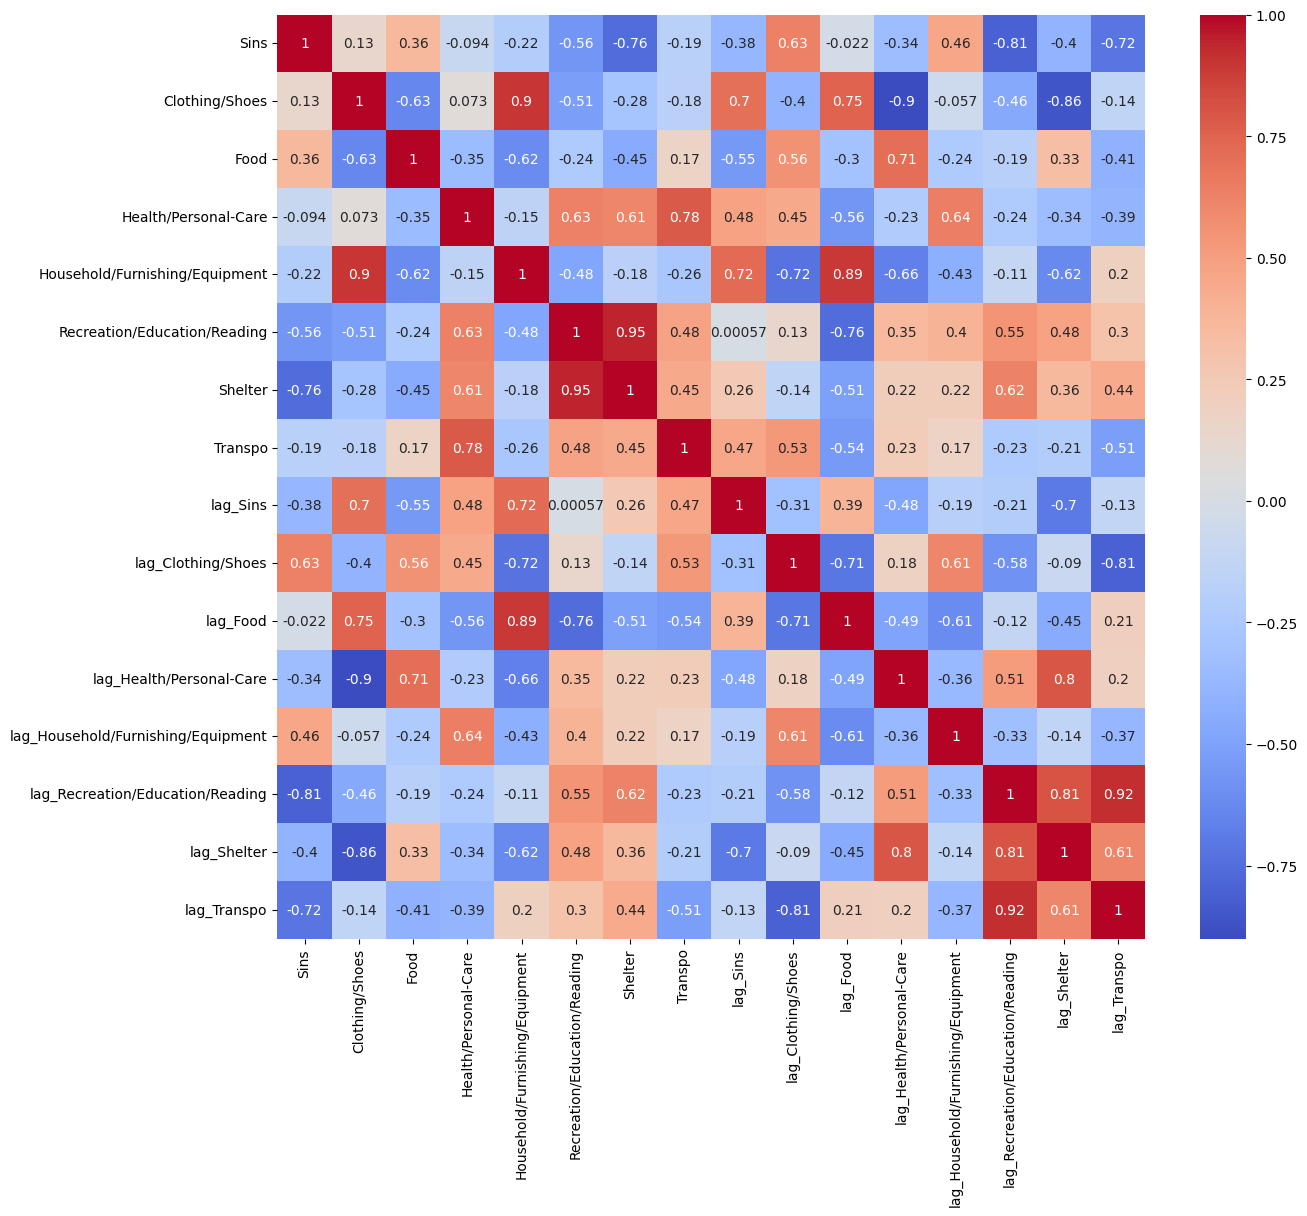

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = extracted_data.corr() # calculate the correlations between the returns of each pair of stocks
plt.figure(figsize=(14, 12))
sns.heatmap(corr,annot=True,cmap="coolwarm")   


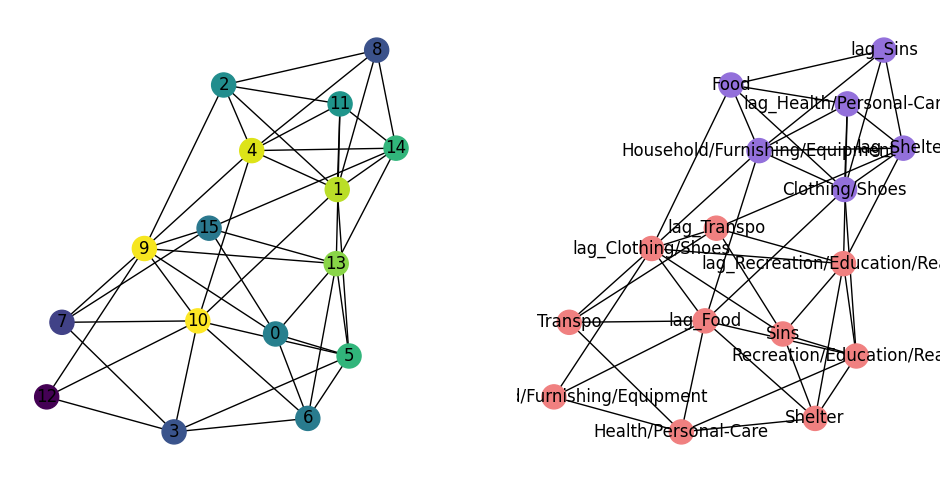

In [161]:
import numpy as np
import networkx as nx

corr_df = pd.DataFrame(corr)
titles = corr_df.columns.tolist()


def truncate(f,relaxer=0.5): #this converts our matrix to 1s and 0s depending on the relaxer value
    if (abs(f) < relaxer):
        return 0
    else:
        return 1

truncated=corr.applymap(truncate)
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
column_numbers=16
adj = truncated-np.identity(column_numbers)
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
adj


IndexedStocknet=stocknet
Indexedstock_layout = nx.spring_layout(IndexedStocknet,seed=column_numbers)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=column_numbers) # fix our layout
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,column_numbers) ]
for i in range(0,column_numbers):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"


eigen_cent = nx.eigenvector_centrality(IndexedStocknet)
eigen_colors = [eigen_cent[i] for i in range(0,column_numbers)]


fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12, 6))

# Draw the graphs in the subplots
nx.draw(IndexedStocknet,Indexedstock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()
    


In [ ]:
    df = pd.DataFrame(eigen_cent,index=[0])
    dfT= pd.DataFrame(titles)
    # print the resulting DataFrame
    mat1=df.T
    mat2=dfT
    Centrality_results = mat1.values.flatten().tolist()
    date_range_df.loc[date_range[x]] = Centrality_results

    

In [ ]:


    
    df = pd.DataFrame(eigen_cent,index=[0])
    dfT= pd.DataFrame(titles)
    # print the resulting DataFrame
    mat1=df.T
    mat2=dfT
    Centrality_results = mat1.values.flatten().tolist()
    date_range_df.loc[date_range[x]] = Centrality_results

    
